In [13]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
groq_api_key = os.getenv("GROQ_API_KEY")
model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

## **Problem**

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [14]:
# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""


## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [15]:
from operator import add
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subject(BaseModel):
    subjects: list[str]
    
class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, add]
    best_selected_joke: str

In [16]:
## Generate subject for jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state['topic'])
    response = model.with_structured_output(Subject).invoke(prompt)
    
    return {
        'subjects': response.subjects
    }

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [17]:
from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {'subject': s}) for s in state['subjects']]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [18]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str
    
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject = state['subject'])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {
        'jokes': [response.joke]
    }

#### Best joke selection form the reduce

In [19]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

# **Graph**

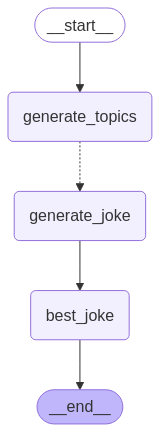

In [20]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [22]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['endangered species', 'animal habitats', 'wildlife conservation']}}
{'generate_joke': {'jokes': ["Why did the endangered species go to therapy? Because it was feeling a little 'extinct'!"]}}
{'generate_joke': {'jokes': ['Why did the tree go to the party in the forest? Because it wanted to branch out and meet new people!']}}
{'generate_joke': {'jokes': ['Why did the conservationist break up with his girlfriend? Because he wanted to protect endangered species, not endangered relationships.']}}
{'best_joke': {'best_selected_joke': 'Why did the conservationist break up with his girlfriend? Because he wanted to protect endangered species, not endangered relationships.'}}
